<a href="https://colab.research.google.com/github/sarayangrh/MAIS202_Final_Project/blob/main/MAIS_model_ipMAynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Downloading and Annotating Data

In [ ]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal
from scipy import signal
import torch

In [ ]:
! rm -r data

Downloading the data

In [ ]:
!mkdir data
!cd data && wget https://archive.org/download/dog-barks-raw/Dog%20Bark%20Data.zip
!cd data && unzip -q "Dog Bark Data.zip"
!ls data/"Dog Bark Data"/Dog

--2025-03-05 03:40:33--  https://archive.org/download/dog-barks-raw/Dog%20Bark%20Data.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dn790000.ca.archive.org/0/items/dog-barks-raw/Dog%20Bark%20Data.zip [following]
--2025-03-05 03:40:33--  https://dn790000.ca.archive.org/0/items/dog-barks-raw/Dog%20Bark%20Data.zip
Resolving dn790000.ca.archive.org (dn790000.ca.archive.org)... 184.105.203.167
Connecting to dn790000.ca.archive.org (dn790000.ca.archive.org)|184.105.203.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1943878068 (1.8G) [application/zip]
Saving to: ‘Dog Bark Data.zip’

Dog Bark Data.zip   100%[===================>]   1.81G  14.4MB/s    in 79s     

2025-03-05 03:41:53 (23.4 MB/s) - ‘Dog Bark Data.zip’ saved [1943878068/1943878068]

ls: cannot access 'data/Dog Bark Data/Dog': No such file or director

Annotating the data

In [ ]:
paths = glob.glob('data/**/**/**/**/*.aif') + glob.glob('data/**/**/**/**/*.wav')

In [ ]:
# This is the number of audiofiles
len(paths)

720

In [ ]:
!mkdir data/audio

In [ ]:
# Copied straight from the Earth Species github
import re
import shutil

filename = []
name = []
context = []

for path in paths:
    try:
        n, session, c, session_sequence, *_ = re.findall('(\w+)', path.split('/')[-1])
        if c not in ['A', 'C', 'P']:
            n, c, *_ = re.findall('(\w+)', path.split('/')[-1])
            if c not in ['A', 'C', 'P']:
                n, _, c = re.findall('(\w+)', path.split('/')[-1])
                c = c[0]
                if c not in ['A', 'C', 'P']: continue
    except:
        continue
    shutil.copy(path, 'data/audio')
    filename.append(path.split('/')[-1])
    name.append(n)
    context.append(c)

In [ ]:
# Copied from Earth Species github
# This code parses the file names to extract the labels
fix_names = {
    'Freid3': 'Freid',
    'Freid4': 'Freid',
    'Fried': 'Freid',
    'Keri3': 'Keri',
    'Kerik': 'Keri',
    'Zzoe': 'Zoe',
    'luke': 'Luke',
    'Louis': 'Louie'

}

name = [n if n not in fix_names.keys() else fix_names[n] for n in name]

age_map = {
    'Farley': 3,
    'Freid': 5,
    'Keri': 4,
    'Louie': 2,
    'Luke': 5,
    'Mac': 5,
    'Roodie': 12,
    'Rudy': 11,
    'Siggy': 11,
    'Zoe': 7
}

weight_map = {
    'Farley': 25,
    'Freid': 6,
    'Keri': 34,
    'Louie': 19,
    'Luke': 25,
    'Mac': 34,
    'Roodie': 18,
    'Rudy': 32,
    'Siggy': 36,
    'Zoe': 16
}

sex_map = {
    'Farley': 'male',
    'Freid': 'male',
    'Keri': 'female',
    'Louie': 'male',
    'Luke': 'male',
    'Mac': 'male',
    'Roodie': 'male',
    'Rudy': 'male',
    'Siggy': 'male',
    'Zoe': 'female'
}

breed_map = {
    'Farley': 'Australian shepherd',
    'Freid': 'Dachsund',
    'Keri': 'Labrador mix',
    'Louie': 'Springer spaniel',
    'Luke': 'Australian shepherd',
    'Mac': 'German shorthair pointer',
    'Roodie': 'Australian cattle dog',
    'Rudy': 'German shorthair pointer',
    'Siggy': 'German shorthair pointer',
    'Zoe': 'Australian cattle dog'
}

age, weight, sex, breed = zip(*[(age_map[n], weight_map[n], sex_map[n], breed_map[n]) for n in name])

In [ ]:
# Copied from Earth Species
# Creates a dataframe with all the different labels corresponding to each bark file
import pandas as pd

anno = pd.DataFrame(data={
    'filename': filename,
    'name': name,
    'context': context,
    'age': age,
    'weight': weight,
    'sex': sex,
    'breed': breed
})
context_map = {
    'A': 'aggression',
    'C': 'contact',
    'P': 'play'
}

anno.context = anno.context.apply(lambda c: context_map[c])

In [ ]:
anno.head()

,filename,name,context,age,weight,sex,breed
0,Roodie-8-C-8k.aif,Roodie,contact,12,18,male,Australian cattle dog
1,Roodie-8-C-8c.aif,Roodie,contact,12,18,male,Australian cattle dog
2,Roodie-8-C-8e.aif,Roodie,contact,12,18,male,Australian cattle dog
3,Roodie-8-C-8o.aif,Roodie,contact,12,18,male,Australian cattle dog
4,Roodie-8-P-8b.aif,Roodie,play,12,18,male,Australian cattle dog


In [ ]:
# Drop empty file
anno = anno[anno.filename != 'Siggy-4-A-4.aif']
# Create a csv file of the annotation
anno.to_csv('data/annotations.csv', index=False)

# 2. Generating Spectrograms

In [ ]:
!cd ..
anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, sr = librosa.load(f'data/audio/{row.filename}', sr=None)
    audio.append(recording)

anno['audio'] = audio

In [ ]:
sample_rate = 44100
def audio_to_spec(audio, sample_rate):
  # Compute spectrogram using SciPy
  freqs, times, Sx = signal.spectrogram(audio, fs=sample_rate)

  freqs, Sx = freqs[:59], Sx[:59]

  # Convert to decibels (log-scale)
  epsilon = 1e-10  # Small constant to avoid log(0)
  Sx = 10 * np.log10(Sx + epsilon)

  return times, freqs, Sx

In [ ]:
def plot_spectrogram(audio, sample_rate, title="Spectrogram"):
    times, freqs, Sx = audio_to_spec(audio, sample_rate)

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(times, freqs / 1000, Sx, cmap='viridis')  # Convert to kHz
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [kHz]')
    plt.title(title)
    plt.colorbar(label='Power (dB)')
    plt.show()



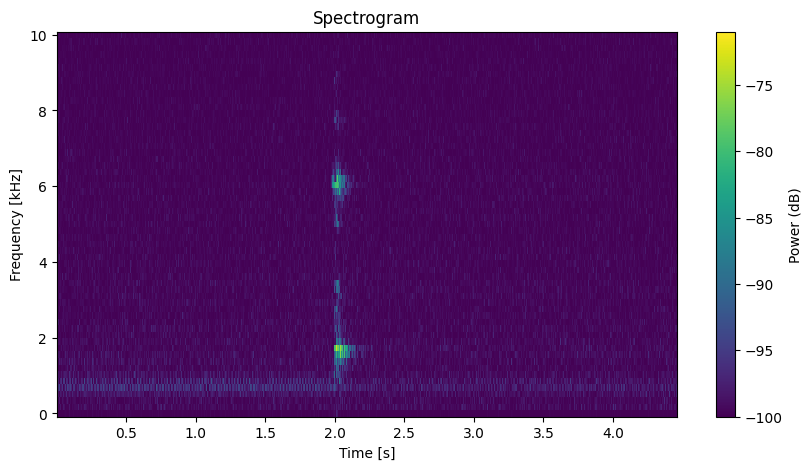

In [ ]:
# example
example_audio = anno["audio"][10]
plot_spectrogram(example_audio, sample_rate)